# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **weather phenomena** (see below) for the region of **None, None, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **None, None, United States** to Ann Arbor, USA. In that case at least one source file must be about **None, None, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **None, None, United States** and **weather phenomena**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **weather phenomena**?  For this category you might want to consider seasonal changes, natural disasters, or historical trends.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

C:\Users\wc5257\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


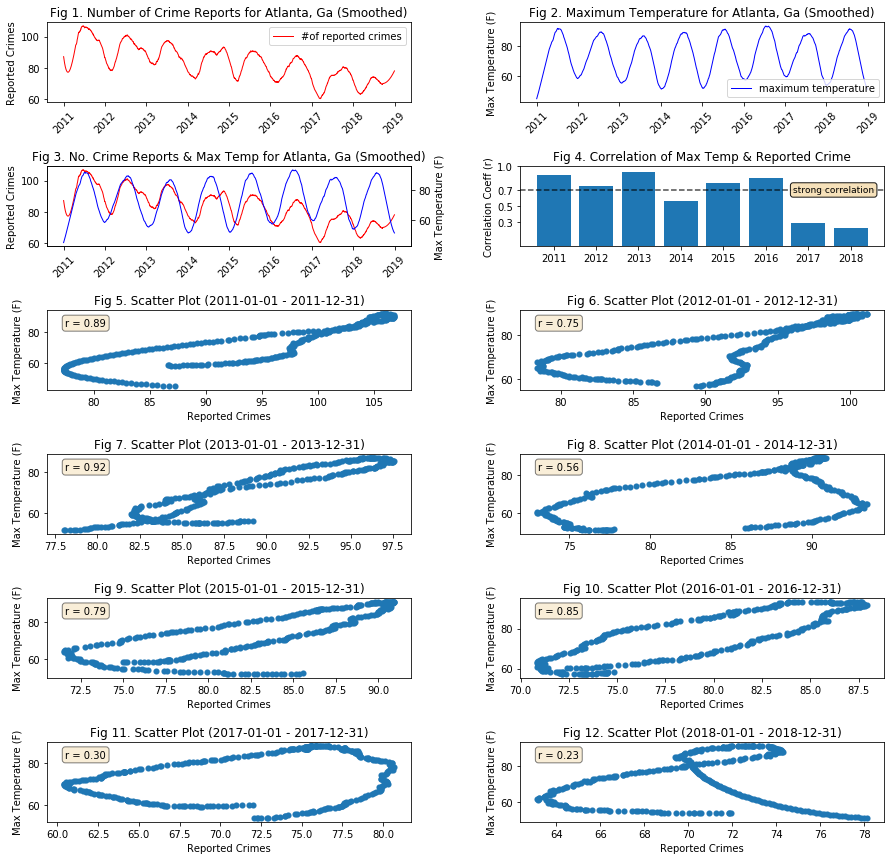

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from scipy.signal import savgol_filter
from matplotlib import gridspec
#import seaborn as sns

#sns.set()
data_df = prepareData()
plotData(data_df)


In [8]:
def prepareData():

    # these are being read locally
    weather_df = pd.read_csv('1728668.csv')
    crime_df = pd.read_csv('COBRA-2009-2018.csv')
    
    # keep specific columns, drop any that have NaH
    weather_cols=['DATE', 'PRCP', 'TMAX', 'TMIN']
    weather_df = weather_df[weather_cols]
    weather_df = weather_df.dropna()
    
    # need per day ('DATE') average of all columns
    weather_cols_avg = {'PRCP':'mean', 'TMAX':'mean', 'TMIN':'mean'}
    weather_result_df = weather_df.groupby(weather_cols[0])[weather_cols[1:4]].agg(['mean']).reset_index()
    
    # keep specific columns
    crime_cols = ['Possible Date']
    crime_df = crime_df[crime_cols]
    crime_df = crime_df.dropna()
    
    # need per day count. the result is a series
    crime_result_s = crime_df['Possible Date'].value_counts()
    crime_result_df = crime_result_s.to_frame()
    crime_result_df = crime_result_df.reset_index()

    #print(weather_result_df.head())
    #print(crime_result_df.head())    
    
    # merge 
    result_df = pd.merge(weather_result_df, crime_result_df, left_on='DATE', right_on='index')
    del result_df['index']
    
    # rename columns
    result_df_cols = {'Possible Date':'Crimes',('PRCP', 'mean'):'Rain',
                      ('TMAX', 'mean'):'Max Temp',('TMIN', 'mean'):'Min Temp',
                      ('DATE', ''):'Date'}
    result_df.rename(columns = result_df_cols, inplace = True)
    
    # Convert date column to type Date
    result_df['Date'] = pd.to_datetime(result_df['Date'], format='%Y-%m-%d')
    
    # add a numerical representation of the date. This will help with the plotting
    result_df['numerical_date'] = result_df['Date'].apply(lambda x: dates.date2num(x))

    # get rid of 2010
    result_df = result_df[result_df['numerical_date'] > 734137]
    result_df = result_df.reset_index()

    return result_df

In [10]:
def plotData(df):
    #plt.clear()
    fig = plt.figure(figsize=(15,20)) #15,10
    gs = gridspec.GridSpec(8, 2)
    plt.subplots_adjust(wspace=.3, hspace=.8)
    
    yhat, yhat2 = createSavgolFilterData(df)
    plotCrimes(plt, df, gs, yhat)
    plotMaxTemp(plt, df, gs, yhat2)
    plotCrimeMaxTemp(plt, df, gs, yhat, yhat2)
    
    # divide data into per year chunks and create scatter plot for each
    # then, store the correlation efficient (r) in an array for plotting
    corr_effs = []
    plot_flags = []
    for i in range(8):
        date_range, gs_coords, plot_flag = getDateAndPosition(i)   
        print
        
        corr_eff = plotCorrelationCrimeTemp(plt, df, gs, yhat, yhat2, date_range, gs_coords, plot_flag, i)
        corr_effs.append(corr_eff)
        plot_flags.append(plot_flag)
    
    # plot a bar graph with the per year corrleation efficients
    corr_effs = np.array(corr_effs)
    plotCorrelationEfficients(plt, gs, corr_effs, plot_flags)


In [12]:
def createSavgolFilterData(df):
    # use savg0l filter to smooth the data for visual representation
    yhat = savgol_filter(df['Crimes'], 199, 3) # window size 199, polynomial order 3
    yhat2 = savgol_filter(df['Max Temp'], 199, 3) # window size 199, polynomial order 3
    return yhat, yhat2

In [13]:
def getDateAndPosition(i):
    date_range = {0 : ('2011-01-01', '2011-12-31'),
                  1 : ('2012-01-01', '2012-12-31'),
                  2 : ('2013-01-01', '2013-12-31'),
                  3 : ('2014-01-01', '2014-12-31'),
                  4 : ('2015-01-01', '2015-12-31'),
                  5 : ('2016-01-01', '2016-12-31'),
                  6 : ('2017-01-01', '2017-12-31'),
                  7 : ('2018-01-01', '2018-12-31'),
                 }
    
    gs_coords = {0 : (2,0),
                 1 : (2,1),
                 2 : (3,0),
                 3 : (3,1),
                 4 : (4,0),
                 5 : (4,1),
                 6 : (5,0),
                 7 : (5,1),
                }
    
    plot_flag = {0 : True,
                 1 : True,
                 2 : True,
                 3 : True,
                 4 : True,
                 5 : True,
                 6 : True,
                 7 : True
                }

    return date_range[i], gs_coords[i], plot_flag[i]

In [14]:
def plotCrimes(plt, df, gs, yhat):
    # create new subplot
    plt.subplot(gs[0, 0])

    # Two axis
    ax = plt.gca()
    
    # plot record low and high data from 2005-2014
    ax.plot(df['numerical_date'], yhat, color='r', lw=1, 
             label='#of reported crimes', zorder=1)

    # Set x axis format (month), remove the last month
    ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(dates.YearLocator())
    loc, labels = plt.xticks()
    loc = loc[1:]
    ax.set_xticks(loc)
    plt.xticks(rotation=45)

    # Label the y axes
    ax.set_ylabel('Reported Crimes')
    plt.legend()
    plt.title('Fig 1. Number of Crime Reports for Atlanta, Ga (Smoothed)')
    
    return

In [15]:
def plotMaxTemp(plt, df, gs, yhat2):
    # create new subplot
    plt.subplot(gs[0, 1])
    
    ax = plt.gca()
    
    # plot record low and high data from 2005-2014
    ax.plot(df['numerical_date'], yhat2, color='b', lw=1, 
             label='maximum temperature', zorder=1)

    # Set x axis format (month), remove the last month
    ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(dates.YearLocator())
    loc, labels = plt.xticks()
    loc = loc[1:]
    ax.set_xticks(loc)
    plt.xticks(rotation=45)
    
    # Label the y axes
    ax.set_ylabel('Max Temperature (F)')
    plt.legend()
    plt.title('Fig 2. Maximum Temperature for Atlanta, Ga (Smoothed)')
    
    return

In [16]:
def plotCrimeMaxTemp(plt, df, gs, yhat, yhat2):
    # create new subplot
    plt.subplot(gs[1, 0])

    # Two axis
    ax = plt.gca()
    ax2 = ax.twinx()
    
    # plot record low and high data from 2005-2014
    ax.plot(df['numerical_date'], yhat, color='r', lw=1, 
             label='# of reported crimes', zorder=1)
    ax2.plot(df['numerical_date'], yhat2, color='b', lw=1, 
             label='max temperature', zorder=1)

    # Set x axis format (month), remove the last month
    ax.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(dates.YearLocator())
    loc, labels = plt.xticks()
    loc = loc[1:]
    ax.set_xticks(loc)
    #plt.xticks(rotation=180) # this doesn't work with this chart for some reason
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    # Label the y axes
    ax.set_ylabel('Reported Crimes')
    ax2.set_ylabel('Max Temperature (F)')

    plt.title('Fig 3. No. Crime Reports & Max Temp for Atlanta, Ga (Smoothed)')

    
    return

In [17]:
def plotCorrelationCrimeTemp(plt, df, gs, yhat, yhat2, date_range, gs_coords, plot_flag, i):
    
    # calculate overall correlation summary
    correlation_df = pd.DataFrame(yhat, yhat2)
    correlation_df = correlation_df.reset_index()
    correlation_df.columns = ['Max Temp', 'Crimes']
    correlation_df['Date'] = df['Date']
    
    # slice data
    correlation_df.set_index('Date', inplace=True)
    #correlation_df = correlation_df.loc['2011-07-01':'2012-6-30']
    correlation_df = correlation_df.loc[date_range[0]:date_range[1]]
    summary = correlation_df.describe()
    
    # calculate correlation cooeficient
    correlation_df['Corr_Data'] = ((correlation_df['Crimes'] - summary.loc['mean']['Crimes']) *
                                   (correlation_df['Max Temp'] - summary.loc['mean']['Max Temp']))
    
    std_Crimes = summary.loc['std']['Crimes']
    std_MaxTemp = summary.loc['std']['Max Temp']
    corr_eff = correlation_df['Corr_Data'].sum() / (std_Crimes*std_MaxTemp)  
    corr_eff = corr_eff / (summary.loc['count']['Crimes'] - 1)
    
    # plot if plot_flag is true
    if plot_flag:
        # create new subplot
        #plt.subplot(gs[1,1])
        plt.subplot(gs[gs_coords[0], gs_coords[1]])
        # create the scatter plot
        ax = plt.gca()
        ax.scatter(correlation_df['Crimes'], correlation_df['Max Temp'], linewidths=.1)     
        textstr = 'r = %.2f'%(corr_eff, )
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.9, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
    
        # Label the x and y axes
        ax.set_ylabel('Max Temperature (F)')
        ax.set_xlabel('Reported Crimes')
        plt.title('Fig '+str(i+5)+'. Scatter Plot ('+date_range[0]+' - '+date_range[1]+')')
        
    return corr_eff
    

In [5]:
def plotCorrelationEfficients(plt, gs, corr_effs, plot_flags):
    plt.subplot(gs[1,1])

    ax = plt.gca()
    
    # plot record low and high data from 2005-2014
    ax.bar(np.arange(len(corr_effs)),corr_effs)
    
    # adjust y axis, 
    ax.set_ylim([0,1])
    plt.yticks([0.3, 0.5, 0.7, 1.0], ('0.3', '0.5', '0.7','1.0'))
    ax.set_ylabel('Correlation Coeff (r)')
    
    # add line to mark strong correlation
    plt.axhline(.7, color='k', alpha=.7, linestyle='--',label='y = {:.0f}'.format(0.7))
    textstr = 'strong correlation'
    props = dict(boxstyle='round', facecolor='wheat', alpha=.9)
    ax.text(0.75, 0.76, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=props)
    
    # adjust x axis, map corr_eff index to year
    dates = {0 : '2011',
             1 : '2012',
             2 : '2013',
             3 : '2014',
             4 : '2015',
             5 : '2016',
             6 : '2017',
             7 : '2018'
            }
    
    # update x asis
    # determine number of x axis ticks
    num_years = 0
    years = []
    for i in range(len(corr_effs)):
        if plot_flags[i] == False: break
        years.append(dates[i])
        num_years += 1
    plt.xticks(np.arange(num_years), years) 
    
    plt.title('Fig 4. Correlation of Max Temp & Reported Crime')
    return
    